In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/plant_disease.zip"

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [6]:
## EDA
len(os.listdir('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'))

38

In [7]:
train_datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train = train_datagen.flow_from_directory(directory='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',target_size=(256,256))

val = val_datagen.flow_from_directory(directory='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',target_size=(256,256))


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [9]:
t_img, label = train.next()

In [10]:
t_img.shape

(32, 256, 256, 3)

In [11]:
def plotImage (img_arr,label):

  for img, l in zip(img_arr,label):

    plt.figure(figsize=(5,5))

    plt.imshow(img/255)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


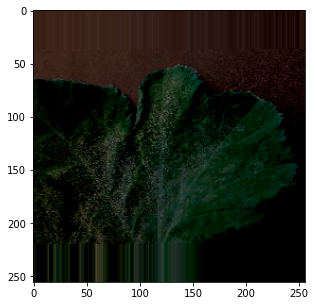

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


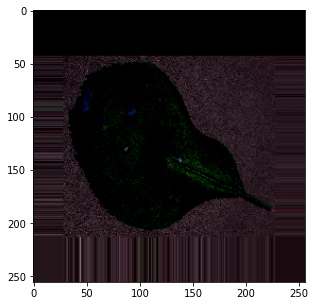

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


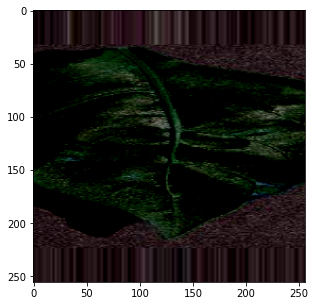

In [12]:
plotImage(t_img[:3],label[:3])

In [13]:
## Model Building

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras


In [14]:
base_model = VGG19(input_shape=(256,256,3),include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
for layer in base_model.layers:
  layer.trainable = False

In [16]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [17]:
X = Flatten()(base_model.output)

X = Dense(units=38,activation='softmax')(X)

## Create final model

model = Model(base_model.input,X)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [20]:
## Early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
es = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)

mc = ModelCheckpoint(filepath='best_model.h5',monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only=True)

cb = [es,mc]

In [22]:
his = model.fit_generator(train,
                          steps_per_epoch=16,
                          epochs=50,
                          verbose=1,
                          callbacks=cb,
                          validation_data=val,
                          validation_steps=16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 59s 1s/step - loss: 25.2099 - accuracy: 0.2070 - val_loss: 13.6167 - val_accuracy: 0.4219

Epoch 00001: val_accuracy improved from -inf to 0.42188, saving model to best_model.h5
Epoch 2/50
16/16 [==============================] - 17s 1s/step - loss: 16.9179 - accuracy: 0.3809 - val_loss: 13.4112 - val_accuracy: 0.5391

Epoch 00002: val_accuracy improved from 0.42188 to 0.53906, saving model to best_model.h5
Epoch 3/50
16/16 [==============================] - 17s 1s/step - loss: 10.9557 - accuracy: 0.5371 - val_loss: 8.2060 - val_accuracy: 0.6367

Epoch 00003: val_accuracy improved from 0.53906 to 0.63672, saving model to best_model.h5
Epoch 4/50
16/16 [==============================] - 17s 1s/step - loss: 9.5079 - accuracy: 0.5859 - val_loss: 5.7982 - val_accuracy: 0.7188

Epoch 00004: val_accuracy improved from 0.63672 to 0.71875, saving model to best_model.h5
Epoch 5/50
16/16 [==============================] - 26s 2s/step - loss: 9.

In [24]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

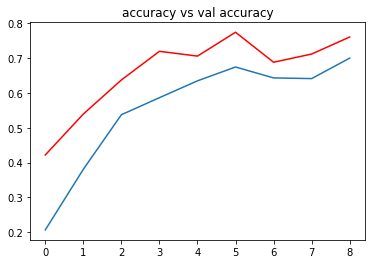

In [28]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title('accuracy vs val accuracy')
plt.show()

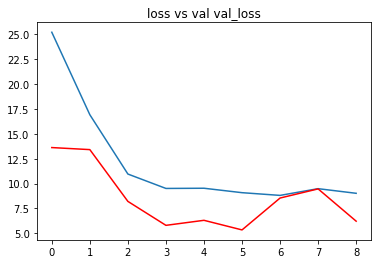

In [29]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title('loss vs val val_loss')
plt.show()

In [30]:
from keras.models import load_model

In [31]:
model = load_model('/content/best_model.h5')

In [32]:
acc = model.evaluate_generator(val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [34]:
acc = acc[1]
acc

In [36]:
print(f'The model accuracy is {acc} %')

The model accuracy is 0.7585362792015076 %


In [63]:
ref = dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [64]:
def predict (path):

  img = load_img(path,target_size=(256,256))

  i = img_to_array(img)

  im = preprocess_input(i)

  img = np.expand_dims(im,axis=0)

  pred = np.argmax(model.predict(img))

  print(f'Image belongs to {ref[pred]}')

In [71]:
path = '/content/test/test/TomatoYellowCurlVirus5.JPG'

In [72]:
predict (path)

Image belongs to Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [74]:
import pickle

In [75]:
diseases_names = open("disease_dict.pkl", "wb")
pickle.dump(ref, diseases_names)
diseases_names.close()

In [76]:
diseases_names = open("disease_dict.pkl", "rb")
output = pickle.load(diseases_names)
print(output)

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To